<a href="https://colab.research.google.com/github/angulartist/Deep-Learning-AnyPercent/blob/master/kaggle/mnist/mnist_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

import os
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')     
%matplotlib inline

import pandas as pd

import numpy as np
from imutils import paths, resize
from google.colab import drive
import cv2

In [119]:
# (Google Colab) - Authorize R/W access to the Drive.

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'deepl/'

base_dir

Mounted at /content/gdrive


'/content/gdrive/My Drive/deepl/'

# Load the MNIST dataset from Keras

In [0]:
(X_train, y_train), (X_ttest, y_ttest) = mnist.load_data()

In [170]:
'''
Let's log the training set shape.

The first column indicates that we have 60 000 training samples
and the two last columns indicate that the dimension of each sample is (h, w) <=> (28, 28).
'''

X_train.shape

(60000, 28, 28)

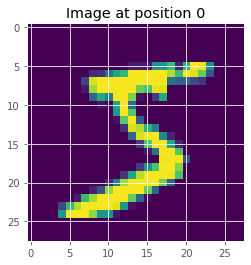

In [171]:
'''
As we can see, we've got 60000 samples in our training set and 10000 samples in our testing set.
Each image, or sample, or datapoint has a dimension of (28, 28) and belongs
to the gray-scale color-space, so their depth equals 1.
'''

plt.imshow(X_train[0])
plt.title(label='Image at position 0')
plt.show()

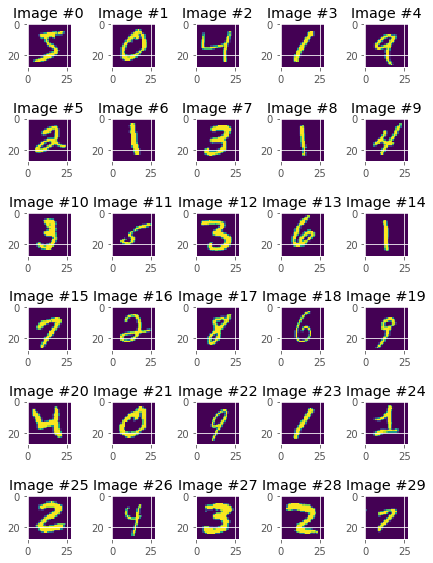

In [172]:
'''
As you can see, images in the MNIST dataset are heavily pre-processed.
That's why this is used as a benchmark dataset and getting very high accuracy is common.
In a real-world problem, we'll need to do some image pre-processing to enchance images
and extract meaningful features.
'''

fig, ax = plt.subplots(
    nrows=6,
    ncols=5,
    figsize=[6, 8]
)

for index, axi in enumerate(ax.flat):
    axi.imshow(X_train[index])
    axi.set_title(f'Image #{index}')

plt.tight_layout(True)
plt.show()

# Normalize pixel intensities to range [0, 1]

In [0]:
'''
Normalization of pixel intensities is adjusting values measured on different scales to a notionally common scale.
That's a best practice you have to follow because weights reach optimum values faster.
Therefore, the network converges faster.

So, instead of having pixel intensities in the range [0, 255] in the gray-scale color-space,
we're going to scale them into the range [0, 1].
There are many normalization techniques and this is one of them.
'''

(X_train, X_ttest) = (child.astype('float32') / 255.0 for child in [X_train, X_ttest])

# Reshape datapoints

In [161]:
'''
Reshape the both training and testing set that way 
the number of samples is the first entry in the matrix,
the single channel as the second entry,
followed by the number of rows and columns.

(num_samples, rows, columns, channel)
'''

X_train = X_train.reshape(-1, 28, 28, 1)
X_ttest = X_ttest.reshape(-1, 28, 28, 1)

# Let's log the new shape.
X_train.shape

(60000, 28, 28, 1)

# One-Hot Encode labels


In [173]:
'''
There are 60000 integers labels for the training set,
each one corresponding to one single datapoint.
That means, for a given Xi datapoint we got a Yi label in the range [0, 9].
For instance, the datapoint at the index 59995 of our training set has the label 8.
'''

pd.DataFrame(y_train)

,0
0,5
1,0
2,4
3,1
4,9
...,...
59995,8
59996,3
59997,5
59998,6


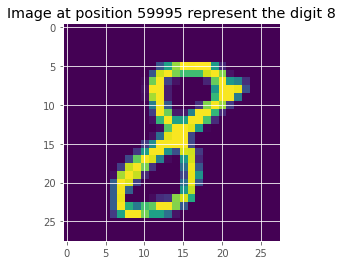

In [174]:
# We can confirm this when plotting the datapoint.

plt.imshow(X_train[59995])
plt.title(label='Image at position 59995 represent the digit 8')
plt.show()

In [103]:
'''
Now, our previous integer labels are converted to vector labels.
This process is called one-hot encoding and most of the machine learning algorithms
benefit from this label representation. 2 = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
8 = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0].

We could also use the to_categorical() function from Keras which yields the exact same values.
'''

lb = LabelBinarizer()
(y_train, y_ttest) = (lb.fit_transform(labels) for labels in [y_train, y_ttest])
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,1,0
59996,0,0,0,1,0,0,0,0,0,0
59997,0,0,0,0,0,1,0,0,0,0
59998,0,0,0,0,0,0,1,0,0,0


# Data Augmentation

In [0]:
'''
Let's apply some data augmentation.

Data augmentation is a set of techniques used to generate new training samples from the original ones
by applying jitters and perturbations such that the classes labels are not changed.
In the context of computer vision, these random transformations can be translating,
rotating, scaling, shearing, flipping etc.

Data augmentation is a form of regularization because the training algorithm is being
constantly presented with new training samples,
allowing it to learn more robust and discriminative patterns
and reducing overfitting.
'''

daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Build the model

In [0]:
'''
Here, we've imported our CNN.

That's a small VGG-like net, with two stacks of (Conv => ReLU => BN) * 2 => POOL => DO
and a Fully-Connected layer at the end.
Pay attention to Batch Normalization and Dropout layers
which help to reduce overfitting.
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense

class CustomNet(object):
    @staticmethod
    def build(width, height, num_classes, depth=3):
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1
        
        # (Conv => ReLU => BN) * 2 => POOL => DO
        model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
         # (Conv => ReLU => BN) * 2 => POOL => DO
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # FC => ReLU
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Softmax
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        
        print(model.summary())
        
        return model

In [106]:
net = CustomNet()

model = net.build(
    width=28,
    height=28,
    num_classes=10,
    depth=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
activation_48 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
activation_49 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 64)       

In [0]:
'''
When the model has seen all of your training samples, we say that one epoch has passed.
We're going to train the model for 50 epochs.
'''

num_epochs = 50

# Set the optimizer and hyperparameters

In [0]:
'''
Let's use an optimization method.

Optimization algorithms are the engines that power neural networks and
enable them to learn patterns from data by tweaking and seeking for optimal weights values.
Most common one is the (Stochastic) Gradient Descent, but I'll use Adam here.

As you can see, the first param is lr, or learning rate.
This is one of the most important hyperparameters we have to tune.
A learning rate is the step your optimization algorithm is going to make toward
the direction that leads to a lower loss function (and a higher accuracy).

If the learning rate is too small, the algorithm is going to make tiny steps slowing down the process.
But on the other hand, if the learning rate is too high,
the algorithm risks to bounce around the loss landscape and not actually “learn” any patterns from your data.
'''

# Initial learning rate
init_lr = 0.001

adam_opt = Adam(
    lr=init_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    decay=0.0
)

'''
Let's now define a learn-rate scheduler.

The decay is used to slowly reduce the learning rate over time.
Decaying the learning rate is helpful in reducing overfitting 
and obtaining higher classification accuracy – the smaller the learning rate is, 
the smaller the weight updates will be. 
We're going to use a polynomial decay. 
Although there are many way to do that.
'''

def polynomial_decay(epoch):
    max_epochs = num_epochs
    base_lr = init_lr
    power = 2.0
    
    return base_lr * (1 - (epoch / float(max_epochs))) ** power

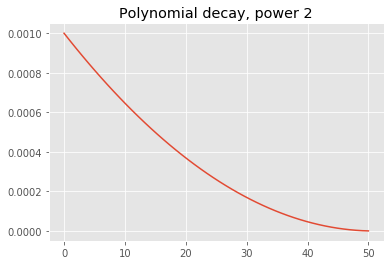

In [175]:
# Let's plot it.

x = np.linspace(0, num_epochs)
fx = [init_lr * (1 - (i / float(num_epochs))) ** 2.0 for i in range(len(x))]
plt.plot(x, fx)
plt.title(label='Polynomial decay, power 2')
plt.show()

# Training time!

In [0]:
'''
Here, we define two callbacks.

Callbacks are functions executed at the end of an epoch.
The first one save our model (checkpoint) whenever the loss decreases (therefore our accuracy improves).
That way we keep the best model. The last one is our learning rate scheduler using the polynomial decay.
'''

checkpointHandler = ModelCheckpoint(
    os.path.join(base_dir, 'best_c10_weights.hdf5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [
    LearningRateScheduler(polynomial_decay),
    checkpointHandler
]

In [111]:
batch_size = 128

print('# Compiling the model...')
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam_opt,
    metrics=['accuracy']
)

print('# Training the network...')
h = model.fit_generator(
    daug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_ttest, y_ttest),
    epochs=num_epochs,
    steps_per_epoch=len(X_train) // batch_size,
    callbacks=callbacks,
    verbose=1
)

# Compiling the model...
# Training the network...
Epoch 1/50
10000/468 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 108us/sample - loss: 6.2934 - acc: 0.1250

Epoch 00001: val_loss improved from inf to 6.73590, saving model to best_c10_weights.hdf5
468/468 [==============================] - 22s 47ms/step - loss: 0.1883 - acc: 0.9426 - val_loss: 6.7359 - val_acc: 0.1250
Epoch 2/50
10000/468 [=

# Evaluate

In [112]:
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

print('# Trained the network! Evaluating...')
preds = model.predict(X_ttest, batch_size=128)
print(classification_report(y_ttest.argmax(axis=1),
preds.argmax(axis=1), target_names=label_names))

# Trained the network! Evaluating...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      1.00      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      1.00      1.00      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



# Visualize curves

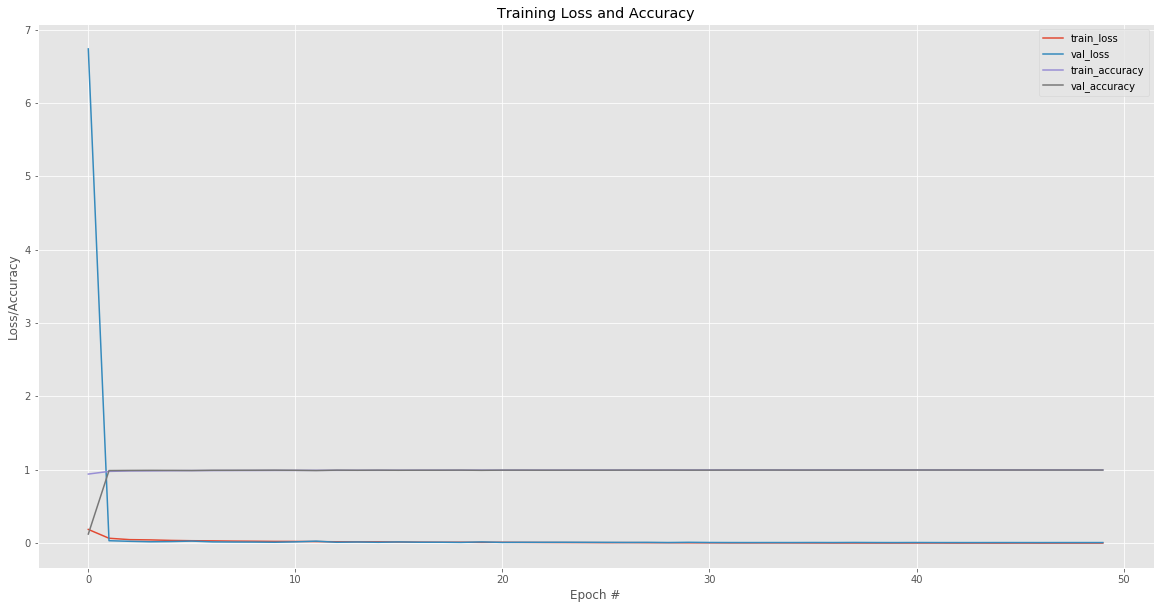

In [113]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, num_epochs), h.history['loss'], label='train_loss')
plt.plot(np.arange(0, num_epochs), h.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, num_epochs), h.history['acc'], label='train_accuracy')
plt.plot(np.arange(0, num_epochs), h.history['val_acc'], label='val_accuracy')

plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()

plt.show()

# Kaggle

In [166]:
'''
Pushing a submission to Kaggle.

First of, load the test set, normalize it and reshape it.
Then, make predictions via the trained model and build the
submission csv file.
'''

sub_X_test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
sub_X_test = sub_X_test / 255.0
sub_X_test = sub_X_test.values.reshape(-1, 28, 28, 1)
preds = model.predict(sub_X_test)
preds = np.argmax(preds, axis=1)
preds = pd.Series(preds, name='Label')
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), preds], axis=1)
submission.to_csv(os.path.join(base_dir, 'cnn_mnist_datagen.csv'), index=False)

print('Saved to:', os.path.join(base_dir, 'cnn_mnist_datagen.csv'))

Saved to: /content/gdrive/My Drive/deepl/cnn_mnist_datagen.csv
